# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [31]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=Yt, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Compare median and mean
    print(Yt.describe())

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(Yt, regression='c', store=True)    # hypothesis: constant
    "KPSS={}".format(kpss_stat)# around a mean

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=Yt, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': y_pred.abs().max(),
        'MIN_ABS': y_pred.abs().min()}


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

# Preprocessing
Feature engineering, create categorial columns

In [22]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')
#df_train.groupby(by=['StateHoliday']).get_group('a').describe()
## StateHoliday -> dummy variable
df_train = pd.concat([df_train, pd.get_dummies(df_train['StateHoliday'], prefix='StateHoliday', dtype=bool)], axis=1)

## StateHoliday -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')

df_train.info()
df_train.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Store           1017209 non-null  int64         
 1   DayOfWeek       1017209 non-null  category      
 2   Date            1017209 non-null  datetime64[ns]
 3   Sales           1017209 non-null  int64         
 4   Customers       1017209 non-null  int64         
 5   Open            1017209 non-null  bool          
 6   Promo           1017209 non-null  bool          
 7   StateHoliday    1017209 non-null  category      
 8   SchoolHoliday   1017209 non-null  bool          
 9   StateHoliday_0  1017209 non-null  bool          
 10  StateHoliday_a  1017209 non-null  bool          
 11  StateHoliday_b  1017209 non-null  bool          
 12  StateHoliday_c  1017209 non-null  bool          
dtypes: bool(7), category(2), datetime64[ns](1), int64(3)
memory usage: 39.8 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,2015-07-31,5263,555,True,True,0,True,True,False,False,False
1,2,5,2015-07-31,6064,625,True,True,0,True,True,False,False,False
2,3,5,2015-07-31,8314,821,True,True,0,True,True,False,False,False
3,4,5,2015-07-31,13995,1498,True,True,0,True,True,False,False,False
4,5,5,2015-07-31,4822,559,True,True,0,True,True,False,False,False


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,True,True,0,True
2015-07-30,1,4,5020,546,True,True,0,True
2015-07-29,1,3,4782,523,True,True,0,True
2015-07-28,1,2,5011,560,True,True,0,True
2015-07-27,1,1,6102,612,True,True,0,True
2015-07-25,1,6,4364,500,True,False,0,False
2015-07-24,1,5,3706,459,True,False,0,False
2015-07-23,1,4,3769,503,True,False,0,False
2015-07-22,1,3,3464,463,True,False,0,False


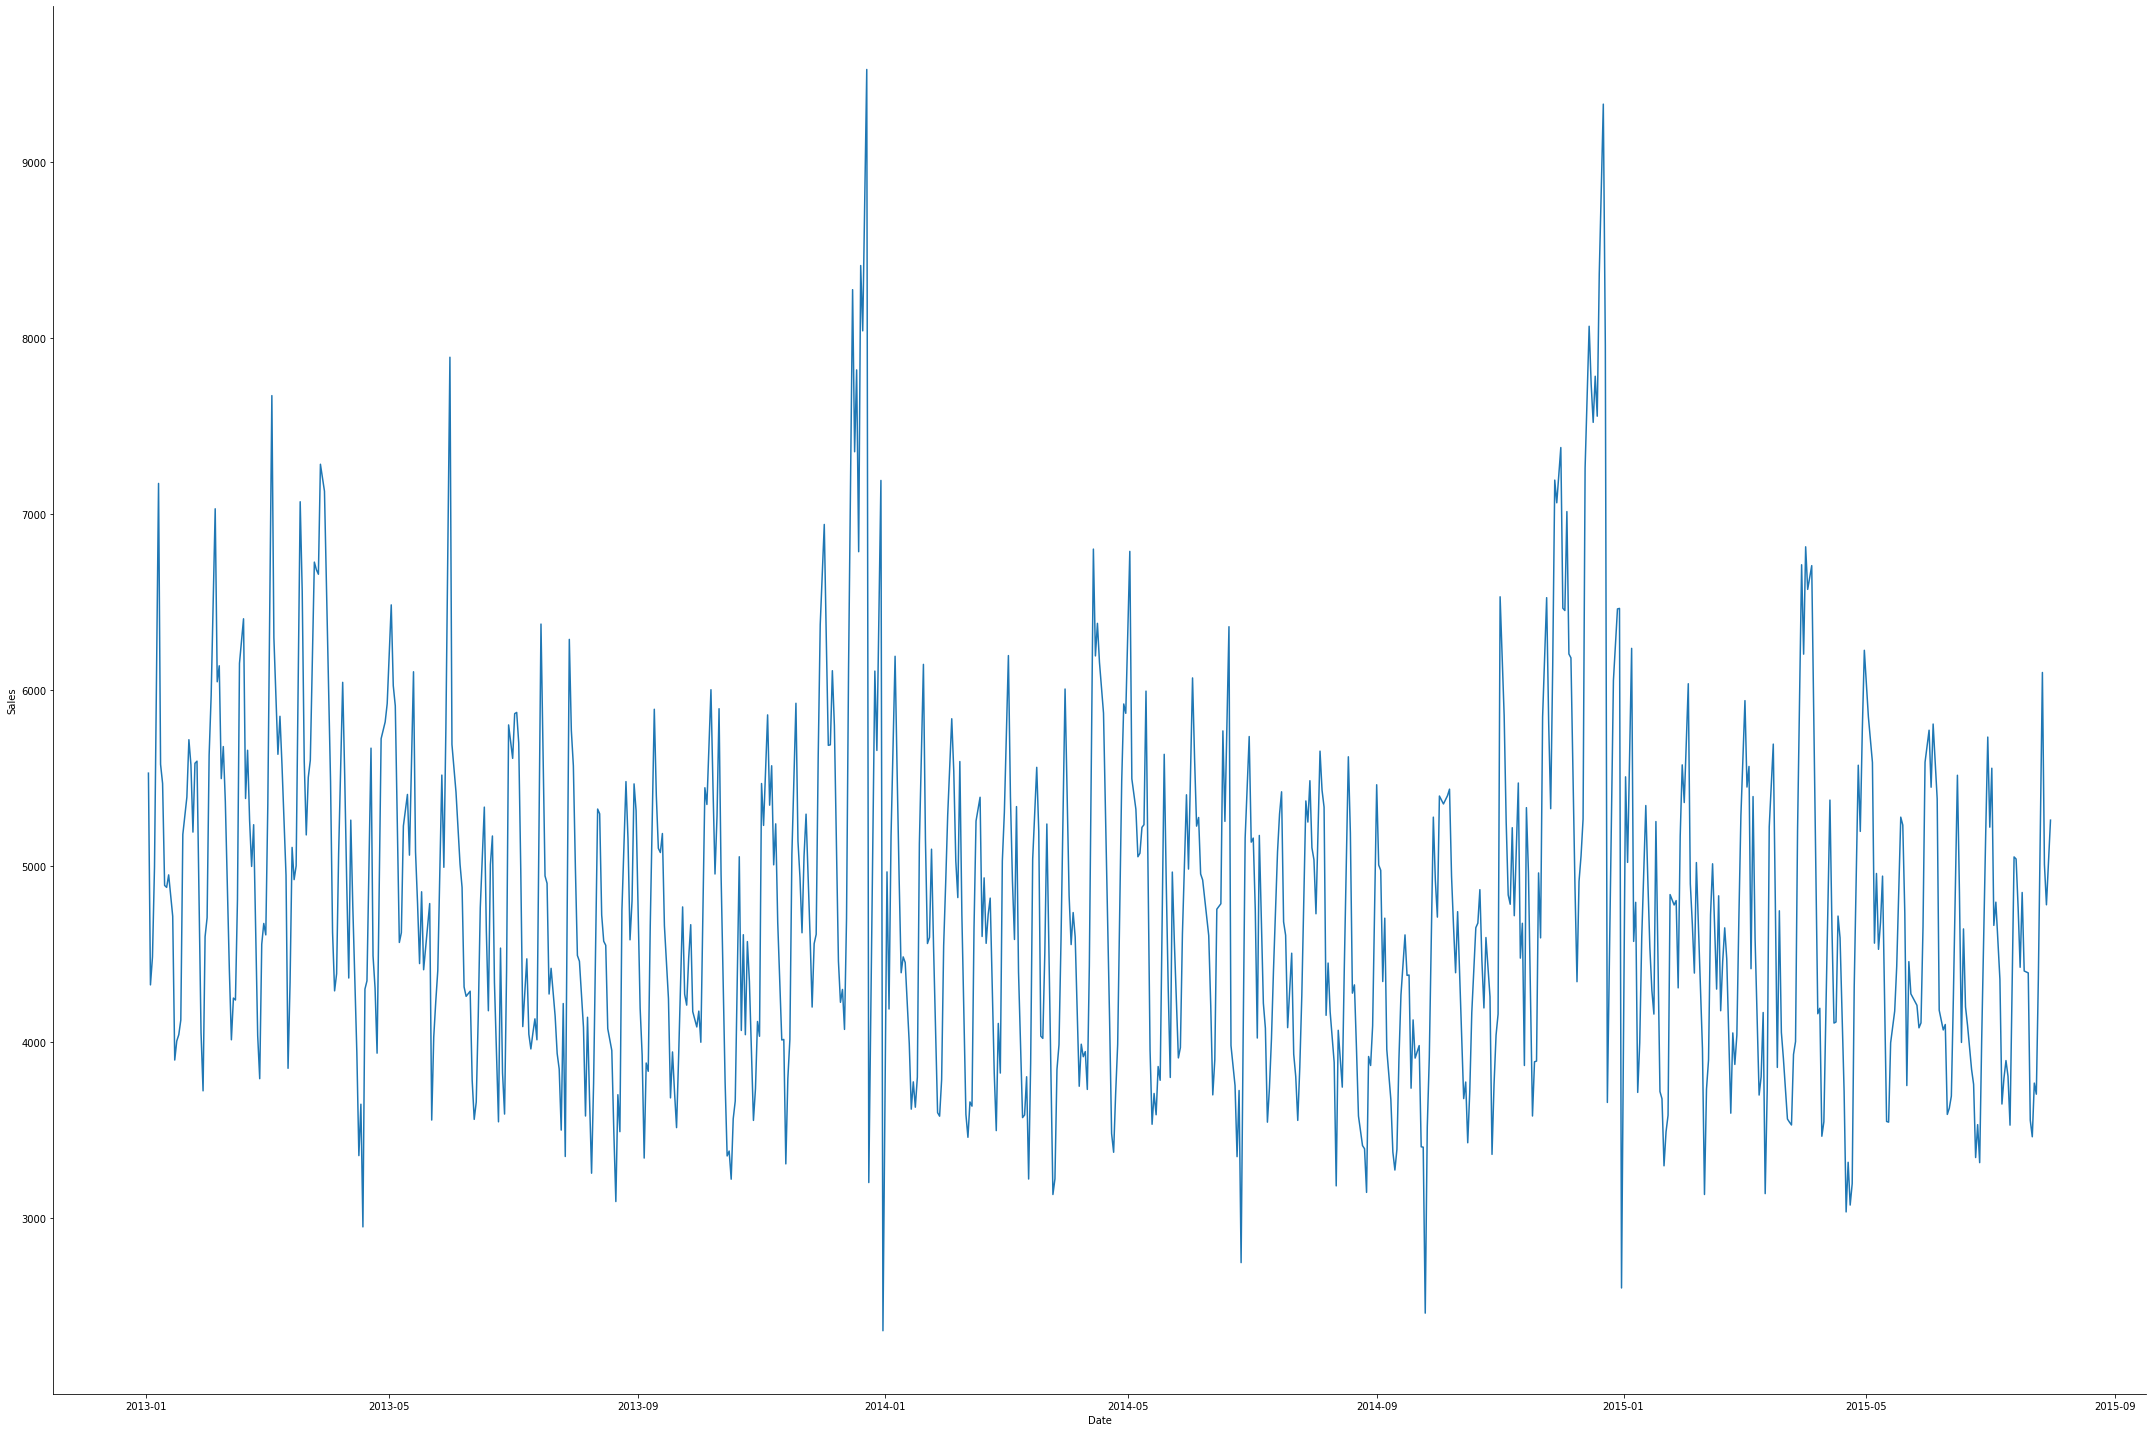

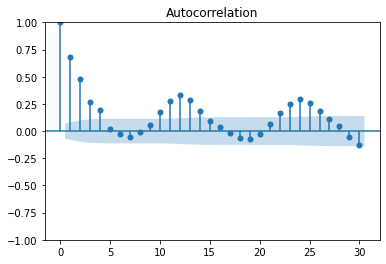

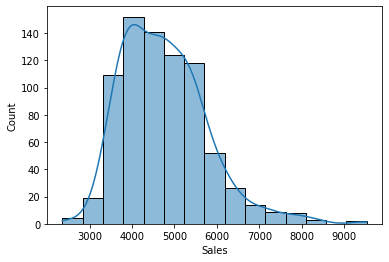

count     781.000000
mean     4759.096031
std      1012.106393
min      2362.000000
25%      4000.000000
50%      4647.000000
75%      5348.000000
max      9528.000000
Name: Sales, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [33]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_train_store_1 = df_train_stores.get_group(1).set_index('Date')
sales_zero_idx = df_train_store_1[df_train_store_1['Sales'] == 0].index
df_train_store_1 = df_train_store_1.drop(sales_zero_idx)
#df_train_store_1['2015-01-01':'2015-02-01'].tail(10)

y_t = df_train_store_1['Sales']

plot_series_hist_acf_kpss(y_t, lags=30)

# Forecast |